# Hurricane Impact on Florida Real Estate Value 

**Final Project: Analyzed the impact of five different hurricanes on Florida Real Estate value using data sourced from Zillow and The National Oceanic and Atmospheric Administration (NOAA).**
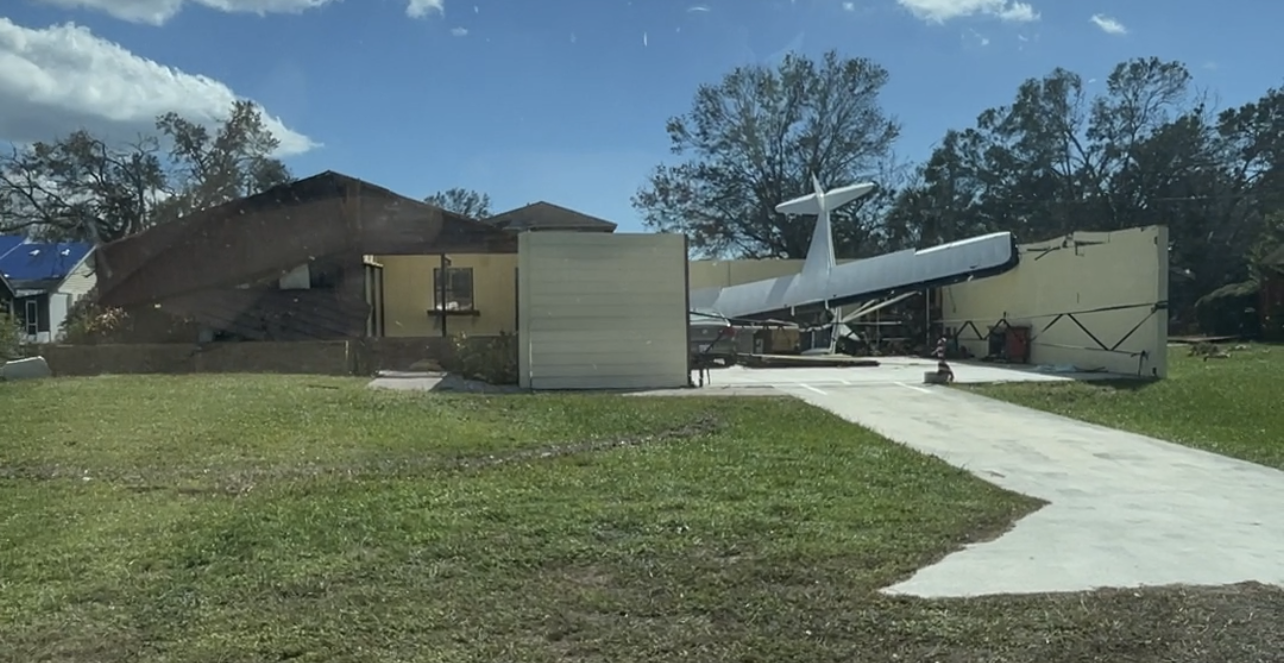

## Summary 

For my capstone project at Flatiron School I used machine learning and classification models to analyze hurricane impact on real estate value. Data from NOAA and Zillow were used to provide the features for the model. The target value was whether or not homes in a region increased in value (encoded as a boolean). If the percentage change in the value of a home was in the 75th percentile or greater six months after a hurricane it was considered to be in the category of increase.  The model features were average wind speed (AWND), fastest 2 minute wind gust (WSF2), size rank of the city (SizeRank), and home value six months before the hurricane (before). The features AWND and WSF2 were used to assess how severely a city had been impacted by a hurricane. 

## Objectives 

My main objective for this project was to help real estate companies understand how hurricanes impact real estate value in an area. Using machine learning classification algorithms I wanted to know if hurricanes hitting an area could be a predictor of home value increase. As a Floridian and survivor of hurricane Charley (2004) and hurricane Ian (2022) I have directly seen the impact hurricanes have on real estate and wanted to see if that could be modeled. The first and most direct impact is the destruction of homes and properties. Followed by the migration of people out of Florida who proceed to sell their homes, either as a result of increasing insurance prices or the trauma of surviving a hurricane. And while having to rebuild our communities is an arduous task–the silver lining is that properties and infrastructure are improved and updated, increasing both home and property value. 

## Importing Necessary Libraries 

In [1]:
#Importing libraries needed
import pandas as pd
import numpy as np

#For Geopy
from tkinter import *
from geopy.geocoders import Nominatim
from geopy.geocoders import Photon

#For visualization
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import seaborn as sns
import shap

# For our modeling steps
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score
import xgboost as xgb 
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn import svm, datasets
from sklearn import metrics


# For demonstrative purposes
from scipy.special import logit, expit

import warnings
warnings.filterwarnings('ignore')

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


## Obtaing Data


In [4]:
#opening the datasets for housing 
#b for bottom tier
bottom_home = pd.read_csv(r'data\zillow_bottom_tier.csv')
#t for top tier 
top_home = pd.read_csv(r'data\zillow_top_tier.csv')
#m for middle tier 
middle_home = pd.read_csv(r'data\zillow_middle_tier.csv')

#opening the datasets for the six hurricanes 
ian = pd.read_csv(r'data\ian.csv')
matthew = pd.read_csv(r'data\matthew.csv')
irma =  pd.read_csv(r'data\irma.csv')
michael =  pd.read_csv(r'data\michael.csv')
charley = pd.read_csv(r'data\charley.csv')
dennis = pd.read_csv(r'data\dennis.csv')

#opening the datasets for joining  
bottom_join =  pd.read_csv(r'data\bottom_housing.csv')
middle_join = pd.read_csv(r'data\middle_housing.csv')
top_join = pd.read_csv(r'data\top_housing.csv')
hurricane = pd.read_csv(r'data\hurricane_cleaned.csv')

#opening the datasets for modeling 
bottom_model =  pd.read_csv(r'data\bottom_hurricane.csv')
middle_model =  pd.read_csv(r'data\middle_hurricane.csv')
top_model =  pd.read_csv(r'data\top_hurricane.csv')
all_model = pd.read_csv(r'data\all_hurricane.csv')

##opening dataset for tuning and wind speed exploration
wind = pd.read_csv(r'data\wind_modeling.csv')

### Data Gathering

In total I used 9 datasets sourced from [Zillow](https://www.zillow.com/research/data/) and [NOAA](https://www.ncei.noaa.gov/cdo-web/search?datasetid=GHCND). Data from Zillow was used in order to provide home value, city, size rank, and home value six months before and six months after the hurricanes. Data from NOAA was used to know the average wind speed and fastest 2 minute wind gust cities in Florida experienced during six hurricanes. Data from both sources was joined into a final dataset and used for the classification models. 

#### Zillow 

Data from [Zillow's Home Value Index (ZHVI)](https://www.zillow.com/research/data/) was used. Zillow Home Value Index is a measure of a home's typical value and market changes across a given region and type of housing. By measuring monthly changes in property across different housing types and geographies Zillow is able to capture how the market price changes and not just the changes in the kinds of markets or property types that sell on a month to month basis. The ZHVI dollar amount is representative of the "typical home value for a region" and not the "median home value".

I looked at three different datasets from Zillow:

**Bottom Tier Homes**: typical value for homes within the 5th to 35th percentile range for a given region.        
**Middle Tier Homes**: typical value for homes within the 35th to 65th percentile range for a given region.     
**Top Tier Homes**: typical value for homes within the 65th to 95th percentile range for a given region.  

| **Column Name** | Description |
| --- | --- |
|**SizeRank** | Numerical rank of size of cities, ranked 0 through 30,132
|**City (RegionName)** | Name of the city
|**State** | State in which the city is located
|**1/31/2000 through 4/30/2023** |refers to the typical home value for the city for January 2000 through April 2023. 

In [11]:
#opening raw data from bottom tier homes 
bottom_home.head()

SizeRank   RegionName State     1/31/2000     2/29/2000     3/31/2000  \
0         0     New York    NY   73546.94209   73946.76925   74343.34862   
1         1  Los Angeles    CA  112089.32630  112263.53370  112762.71010   
2         2      Houston    TX   48111.19222   48108.47093   48052.63010   
3         3      Chicago    IL   29056.60823   29052.14635   29125.11876   
4         4  San Antonio    TX   45948.02234   45991.78734   46030.67980   

      4/30/2000     5/31/2000     6/30/2000     7/31/2000  ...    7/31/2022  \
0   75095.91259   75842.91256   76652.47580   77527.39999  ...  399958.9938   
1  113750.27700  114986.09250  116189.60010  117426.37990  ...  646517.8834   
2   48041.43903   48027.80552   48103.86021   48228.17524  ...  181383.9139   
3   29292.67884   29525.58886   29791.59582   30051.11419  ...  147818.5898   
4   46100.98692   45934.89454   45693.94046   45423.95268  ...  169288.3601   

     8/31/2022    9/30/2022   10/31/2022   11/30/2022   12/31/2022  \
0  398538.0104  394788.8168  392021.4489  390187.7115  387184.3699   
1  647752.3961  648197.0072  648131.1708  648760.6827  647809.0806   
2  182752.5078  183677.1055  184511.6160  185301.2760  185347.5073   
3  146531.3177  145614.5397  145200.3897  145443.5121  145415.2181   
4  169487.9838  168653.8119  168004.1169  167655.3554  167255.8228   

     1/31/2023    2/28/2023    3/31/2023    4/30/2023  
0  383788.7193  382145.1127  384048.2507  387345.7413  
1  645275.1817  641420.7654  639366.1883  639363.8433  
2  185126.4390  184624.9397  184651.1199  184643.4411  
3  148220.6982  152200.0653  156555.5920  158864.1127  
4  168221.6337  169318.9405  171007.3327  171086.2593  

[5 rows x 283 columns]

#### NOAA 

Data was obtained from the National Oceanic and Atmospheric Administration (NOAA) and National Climatic Data Center (NCDC) using the [Climate Data Online (CDO) database](https://www.ncei.noaa.gov/cdo-web/search?datasetid=GHCND). The CDO provides free access to NCDC's archive of global historical weather and climate data in addition to station history information. These data include quality controlled daily, monthly, seasonal, and yearly measurements of temperature, precipitation, wind, and degree days as well as radar data and 30-year Climate Normals. For the purpose of this project all data was downloaded in CSV format, but PDF and Daily Text was available as well. 

Data from NOAA was selected because it provides daily summaries for average wind speed and fastest 2 minute wind gusts for the six hurricanes I wanted to examine.

For the purpose of this project I looked at six hurricanes: Charley (08/2004), Dennis (07/2005), Matthew (10/2016), Irma (09/2017), Michael (10/2018), and Ian (09/2022). I used information from hurricane Charley, Dennis, Matthew, Irma, and Michael to create classification models and validated the model with recent data from hurricane Ian.


|Column Name | Description | 
|---|---|
| **NAME**| is the name of the station (usually city/airport name). 
|**LATITUDE** | latitude (decimated degrees w/northern hemisphere values > 0, southern hemisphere values < 0)
| **LONGITUDE** |  longitude (decimated degrees w/western hemisphere values < 0, eastern hemisphere values > 0) 
| **DATE** |is the year of the record (4 digits) followed by month (2 digits) and day (2 digits).
|**AWND** |Average daily wind speed (meters per second) |    
|**WSF2** |  Fastest 2-minute wind speed (in meters per second) |  

In [14]:
#raw data from hurricane Charley
charley.head()

NAME  LATITUDE  LONGITUDE       DATE  AWND  WSF2
0      FORT PIERCE, FL US   27.4419   -80.3508  8/13/2004   NaN   NaN
1      FORT PIERCE, FL US   27.4419   -80.3508  8/14/2004   NaN   NaN
2  FORT PIERCE ARC, FL US   27.4272   -80.4053  8/13/2004   NaN   NaN
3  FORT PIERCE ARC, FL US   27.4272   -80.4053  8/14/2004   NaN   NaN
4      BIG CYPRESS, FL US   26.3283   -80.9958  8/13/2004   NaN   NaN

### Final Dataset 

I used three datasets for the purpose of modeling. The datasets each contained the same 9 columns: 

**City**: City name   
**HurricaneName**: Name of the hurricane     
**AWND**: Average daily wind speed (miles per hour)      
**WSF2**: Fastest 2-minute wind speed (miles per hour)   
**SizeRank**: Numerical rank of size of cities, ranked 0 through 30,132   
**before**: Home value six months before the hurricane    
**after**: Home value six months after the hurricane     
**percent**: Percent change in home value from six months before hurricane to six months after hurricane    
**increase**: 1 = increase of 75% of more in home value, 0 = no increase of 75% of more in home value  


In [15]:
#modeling dataset 
bottom_model.head()

City HurricaneName       DATE     AWND      WSF2  SizeRank  \
0  Apalachicola       charley  8/14/2004   5.8200  13.00000     12877   
1  Apalachicola        dennis  7/10/2005  19.4600  30.00000     12877   
2  Apalachicola        dennis  7/11/2005  17.0000  32.00000     12877   
3  Apalachicola           ian  9/28/2022  38.0273  57.93571     12877   
4  Apalachicola          irma  9/11/2017  20.8000  36.90000     12877   

        before        after    percent  increase  
0  33025.67901  41196.08834  24.739565         1  
1  40369.46137  50891.84431  26.065205         0  
2  40369.46137  50891.84431  26.065205         0  
3  65287.07867  76710.34737  17.496982         1  
4  52379.75722  63594.00344  21.409504         1

## Data Scrubbing 
### Missing Values 
The datasets were missing less than 10% of their values. For the purpose of this project I chose to drop missing values rather than fill them using the mean or some other method because we needed the dataset to accurately reflect extreme values, such as max average wind speed. 
### Duplicate Values 
Duplicate values were dropped based on city. Only one city was kept per hurricane based on the max average wind speed it experienced. 

### Outliers
Outliers were left in the dataset since I was looking at extreme weather phenomenoms. 

In [21]:
#function to limit dataset to just Florida and drop 'State' column
def clean(df):
    #limiting the dataset to just the state of Florida
    df = df[df["State"] == 'FL']
    
    #State is not needed because we are just looking at Florida 
    df = df.drop(['State'], axis = 1)
    
    #renaming RegionName to City
    df.rename(columns={"RegionName": "City"}, inplace=True)
    return df

#applying functions to each dataset 
middle_home = clean(middle_home)
top_home = clean(top_home)
bottom_home = clean(bottom_home)

In [22]:
bottom_home.head()

SizeRank          City    1/31/2000    2/29/2000    3/31/2000  \
12        12  Jacksonville  34345.37809  34401.37835  34463.49336   
16        16       Orlando  54399.11437  54514.30500  54714.68168   
20        20         Miami  52834.56992  53017.65767  53177.81077   
50        50         Tampa  32442.30379  32592.93576  32737.85510   
72        73        Naples  83105.88309  83134.46159  83478.57626   

      4/30/2000    5/31/2000    6/30/2000    7/31/2000    8/31/2000  ...  \
12  34614.56979  34789.20541  34996.77934  35192.79405  35391.75152  ...   
16  55081.25437  55486.76470  55874.25600  56210.07840  56566.77885  ...   
20  53521.19432  53839.20505  54211.19784  54577.85622  54919.54921  ...   
50  33051.73181  33342.68522  33657.53924  33972.43003  34338.87583  ...   
72  84091.82543  84915.45576  85595.77587  86266.00124  86925.76307  ...   

      7/31/2022    8/31/2022    9/30/2022   10/31/2022   11/30/2022  \
12  187590.7456  189515.9287  190775.0400  191839.7007  192698.8167   
16  243928.0328  246786.3514  248328.3332  249230.4373  249816.9945   
20  329742.3198  334606.7074  337704.5881  340128.4449  342641.2198   
50  251529.9763  254030.2425  254518.9993  253967.9508  252807.7942   
72  362207.6816  364857.2696  364792.3262  364582.9405  364611.2212   

     12/31/2022    1/31/2023    2/28/2023    3/31/2023    4/30/2023  
12  192713.3347  192967.5721  193338.1168  193760.5524  193123.0721  
16  249725.2163  249407.3346  249355.3493  250118.6039  251411.5288  
20  344626.0065  347306.7690  350039.6459  353429.2108  356632.3031  
50  251112.4007  250688.8581  251079.9941  252307.7222  252842.1937  
72  364276.5817  364523.8983  365399.1955  367905.2924  370182.7882  

[5 rows x 282 columns]

In [23]:
#let's get rid of duplicate cities by only grabbing the cities with the max value for AWND
bottom_model = bottom.sort_values('AWND', ascending=False).drop_duplicates(['HurricaneName', 'City']).sort_index()
middle_model = middle.sort_values('AWND', ascending=False).drop_duplicates(['HurricaneName', 'City']).sort_index()
top_model = top.sort_values('AWND', ascending=False).drop_duplicates(['HurricaneName', 'City']).sort_index()
all_model = all_df.sort_values('AWND', ascending=False).drop_duplicates(['HurricaneName', 'City', 'DATE']).sort_index()

In [24]:
bottom_model.head()

City HurricaneName       DATE     AWND      WSF2  SizeRank  \
0  Apalachicola       charley  8/14/2004   5.8200  13.00000     12877   
1  Apalachicola        dennis  7/10/2005  19.4600  30.00000     12877   
3  Apalachicola           ian  9/28/2022  38.0273  57.93571     12877   
4  Apalachicola          irma  9/11/2017  20.8000  36.90000     12877   
7  Apalachicola       matthew  10/7/2016  10.7400  21.90000     12877   

        before        after    percent  increase  
0  33025.67901  41196.08834  24.739565         1  
1  40369.46137  50891.84431  26.065205         0  
3  65287.07867  76710.34737  17.496982         1  
4  52379.75722  63594.00344  21.409504         1  
7  48548.85811  52980.36723   9.127937         0

## Feature Engineering 

In order to create our models I needed to engineer two additional features: home value increase and city. 

### Using GeoPy to Get Cities

Data from NOAA provided location information in the form of latitude and longitude while data from Zillow provided location information in the form of city. In order to join the data from NOAA to the data from Zillow I needed to know the city names. Using the coordinates provided by the NOAA dataset I used GeoPy to reverse geolocate the city names.



In [18]:
#Engingeering a coordinates column out of latitude and longitude 
#We need coordinates to use geopy 

hurricane['COORD'] = list(zip(hurricane.LATITUDE, hurricane.LONGITUDE))

hurricane.head()

NAME  LATITUDE  LONGITUDE       DATE  \
5   JACKSONVILLE INTERNATIONAL AIRPORT, FL US  30.49529  -81.69374  8/14/2004   
9                     CRESTVIEW FAA AP, FL US  30.77715  -86.51938  8/13/2004   
15          MARIANNA MUNICIPAL AIRPORT, FL US  30.83696  -85.18352  8/13/2004   
16          PENSACOLA REGIONAL AIRPORT, FL US  30.47612  -87.18575  8/13/2004   
25            NAPLES MUNICIPAL AIRPORT, FL US  26.15498  -81.77514  8/13/2004   

         AWND      WSF2 HurricaneName                  COORD  
5   14.517481  44.51431       charley  (30.49529, -81.69374)  
9   16.016204  29.07970       charley  (30.77715, -86.51938)  
15  15.501717  29.07970       charley  (30.83696, -85.18352)  
16  22.011096  36.01409       charley  (30.47612, -87.18575)  
25  20.512373  78.06781       charley  (26.15498, -81.77514)

In [19]:
#creating a function 
def get_city(coords):
    #instantiate the Nominatim API 
    geolocator = Nominatim(user_agent="MyApp")
    #get the city from the coordinates 
    location = geolocator.reverse(coords)
    address = location.raw['address']
    city = address.get('city', '')
    #return the city 
    return city

In [20]:
#applying function to dataframe
hurricane['City'] = hurricane['COORD'].apply(get_city)

### Home Value Increase

Since this was a classification problem the target variable has to be in the form of a class. Using home value data from six months before and after each hurricane I engineered a column that contained two categories, increased significantly (coded as 1) and did not increase significantly (coded as 0). If the percentage change in the value of a home was in the 75th percentile six months after a hurricane it was considered to be in the category 1, if not then 0.
The dates we will look at six months before and after each hurricane are as follows: 
 

| Hurricane | 6 Months Before | 6 Months After |
| -- | -- | -- |
|Charley | 2/2004 | 2/2005 |     
|Dennis | 1/2005 | 1/2006 |
|Matthew | 4/2016 | 4/2017 |
|Irma | 3/2017 | 3/2018 |
|Michael | 4/2018 | 4/2019 |  
|Ian | 3/2022 | 3/2023 |

#### Writing Functions
Let's write a functions to make scrubbing and engineering our three dataframes simpler. This function will: 
- rename the date columns six months before and after the hurricane
- give us the percent change in home value six months before and after the hurricane 
- create a column telling us if the percent increase was more than 75% 
- and convert the dataframe from wide to long format 

In [39]:
#writing function to rename 
#Renaming the columns 6 months before and after each hurricane 
#b = before a = after
def renaming(df):
    

    #Charley 2/29/2004 2/28/2005
    df['before_charley'] = df['2/29/2004']
    df['after_charley'] = df['2/28/2005']

    #Dennis 1/31/2005 1/31/2006
    df['before_dennis'] = df['1/31/2005']
    df['after_dennis'] = df['1/31/2006']

    #Matthew 4/30/2016 4/30/2017
    df['before_matthew'] = df['4/30/2016']
    df['after_matthew'] = df['4/30/2017']

    #Irma 3/31/2017 3/31/2018
    df['before_irma'] = df['3/31/2017']
    df['after_irma'] = df['3/31/2018']

    #Michael 4/30/2018 4/30/2019
    df['before_michael'] = df['4/30/2018']
    df['after_michael'] = df['4/30/2019']
    
    #Ian 3/30/2022 - 3/30/2023
    df['before_ian'] = df['4/30/2018']
    df['after_ian'] = df['4/30/2019']
    
    

    #dropping all unecessary date columns 
    df.drop(df.iloc[:, 2:282], inplace=True, axis=1)
    return df

In [40]:
#applying the function to our dataframes 
df_list = [bottom, middle, top]
df_list = [df.pipe(renaming) for df in df_list]

In [41]:
#writing function to find percent change in home value 
#percent = (after - before/before)*100
def percent(df):

    #finding percent change for Hurricane Charley
    df['percent_charley'] = (df['after_charley'] - df['before_charley'])/df['before_charley']*100

    #finding percent change for Hurricane Dennis
    df['percent_dennis'] = (df['after_dennis'] - df['before_dennis'])/df['before_dennis']*100

    #finding percent change for Hurricane Matthew
    df['percent_matthew'] = (df['after_matthew'] - df['before_matthew'])/df['before_matthew']*100

    #finding percent change for Hurricane Irma
    df['percent_irma'] = (df['after_irma'] - df['before_irma'])/df['before_irma']*100

    #finding percent change for Hurricane Michael
    df['percent_michael'] = (df['after_michael'] - df['before_michael'])/df['before_michael']*100
    
    #finding percent change for Hurricane Ian
    df['percent_ian'] = (df['after_ian'] - df['before_ian'])/df['before_ian']*100
    
    return df

In [42]:
#applying the function to our dataframes 
df_list = [bottom, middle, top]
df_list = [df.pipe(percent) for df in df_list]

In [43]:
#checking it out the dataframe
bottom.head()

SizeRank              City  before_charley  after_charley  before_dennis  \
12        12      Jacksonville     46528.30349    52803.32790    52229.68266   
16        16           Orlando     75863.27537    88560.22345    87103.38849   
20        20             Miami     86752.55847   106338.70750   104500.57250   
50        50             Tampa     51585.41060    61309.89329    60275.09126   
83        84  Saint Petersburg     47796.13229    57880.05754    56710.46260   

    after_dennis  before_matthew  after_matthew   before_irma    after_irma  \
12   61480.05435     61641.02096    75455.15986   74368.72970   89549.52993   
16  114235.08580    102850.32070   118552.61400  117150.03700  135916.26840   
20  132340.36560    146481.11150   163017.67470  161172.11980  184837.77680   
50   77788.70274     79355.75107    99124.85991   97518.91551  117410.61150   
83   72152.72440     68565.21894    82501.63073   81409.82809   97547.95759   

    before_michael  after_michael    before_ian    after_ian  percent_charley  \
12     90687.07496    107991.1522   90687.07496  107991.1522        13.486467   
16    137614.49960    156611.1060  137614.49960  156611.1060        16.736620   
20    187941.97110    204898.3950  187941.97110  204898.3950        22.577028   
50    119123.71920    132794.8740  119123.71920  132794.8740        18.851227   
83     98235.48434    111763.8544   98235.48434  111763.8544        21.097785   

    percent_dennis  percent_matthew  percent_irma  percent_michael  \
12       17.710948        22.410626     20.412881        19.081084   
16       31.148843        15.267131     16.018972        13.804219   
20       26.640804        11.289212     14.683468         9.022159   
50       29.056134        24.912005     20.397782        11.476434   
83       27.230005        20.325775     19.823318        13.771368   

    percent_ian  
12    19.081084  
16    13.804219  
20     9.022159  
50    11.476434  
83    13.771368

In [44]:
#function to create a boolean column for home value increase
def bool(df):
    
    #using cutoff to create boolean value 
    #cutting off at 75%
    #1 = True (increase of more than 75%) 
    #0 = False (no increase of more than 75%)
    
    #creating bool column for charley
    df['increase_charley'] = np.where(df['percent_charley'] >= (df['percent_charley'].quantile(.75)), 1, 0)
    
    #creating bool column for dennis
    df['increase_dennis'] = np.where(df['percent_dennis'] >= (df['percent_dennis'].quantile(.75)), 1, 0)
    
    #creating bool column for matthew
    df['increase_matthew'] = np.where(df['percent_matthew'] >= (df['percent_matthew'].quantile(.75)), 1, 0)
    
    #creating bool column for irma
    df['increase_irma'] = np.where(df['percent_irma'] >= (df['percent_irma'].quantile(.75)), 1, 0)
    
    #creating bool column for michael
    df['increase_michael'] = np.where(df['percent_michael'] >= (df['percent_michael'].quantile(.75)), 1, 0)
    
     #creating bool column for ian
    df['increase_ian'] = np.where(df['percent_ian'] >= (df['percent_ian'].quantile(.75)), 1, 0)
    
    #Using pandas wide_to_long (https://pandas.pydata.org/docs/reference/api/pandas.wide_to_long.html)
    #j = hurricane name
    #i = city 
    #stubname = name of variables
    
    df = pd.wide_to_long(df, stubnames = ['before', 'after', 'percent', 'increase'], i= ['City'], j= 'HurricaneName', sep = '_', suffix = r'\w+')
    
    #reseting index
    df.reset_index(inplace=True)

    return df

In [45]:
#applying the function to our dataframes 
bottom = bool(bottom)
middle = bool(middle)
top = bool(top)

In [46]:
#checking it out
bottom.head()

City HurricaneName  SizeRank       before         after  \
0      Jacksonville       charley        12  46528.30349   52803.32790   
1           Orlando       charley        16  75863.27537   88560.22345   
2             Miami       charley        20  86752.55847  106338.70750   
3             Tampa       charley        50  51585.41060   61309.89329   
4  Saint Petersburg       charley        84  47796.13229   57880.05754   

     percent  increase  
0  13.486467         0  
1  16.736620         0  
2  22.577028         0  
3  18.851227         0  
4  21.097785         0

## Joining Datasets 

In [9]:
#function to join housing and hurricane datasets
def join(df):
    #setting the index
    df.set_index(['City', 'HurricaneName'], inplace = True)
    #joining the dataframe
    df = hurricane.join(df, how='inner')
    #reseting the index
    df.reset_index(inplace = True)
    return df

### Joining Bottom Tier Home Values with Hurricane Data

In [10]:
#applying function
bottom_hurricane = join(bottom)
#looking at results
bottom_hurricane

City HurricaneName        DATE     AWND      WSF2  SizeRank  \
0    Apalachicola       charley   8/14/2004   5.8200  13.00000     12877   
1    Apalachicola        dennis   7/10/2005  19.4600  30.00000     12877   
2    Apalachicola        dennis   7/11/2005  17.0000  32.00000     12877   
3    Apalachicola           ian   9/28/2022  38.0273  57.93571     12877   
4    Apalachicola          irma   9/11/2017  20.8000  36.90000     12877   
..            ...           ...         ...      ...       ...       ...   
428  Winter Haven       matthew   10/7/2016  13.4200  25.90000       395   
429  Winter Haven       matthew   10/8/2016   8.7200  18.10000       395   
430  Winter Haven       michael  10/11/2018   7.3800  16.10000       395   
431  Winter Haven       michael  10/10/2018  13.2000  25.10000       395   
432  Winter Haven       michael   10/9/2018  11.6300  18.10000       395   

          before         after    percent  increase  
0    33025.67901   41196.08834  24.739565         1  
1    40369.46137   50891.84431  26.065205         0  
2    40369.46137   50891.84431  26.065205         0  
3    65287.07867   76710.34737  17.496982         1  
4    52379.75722   63594.00344  21.409504         1  
..           ...           ...        ...       ...  
428  69267.39054   80862.30360  16.739353         1  
429  69267.39054   80862.30360  16.739353         1  
430  94132.64063  110238.51310  17.109764         1  
431  94132.64063  110238.51310  17.109764         1  
432  94132.64063  110238.51310  17.109764         1  

[433 rows x 10 columns]

## Data Exploration and Visualization

### Change in Home Value

Let's graph home value to visualize how how home prices have changed six months before and six months after each hurricane. As we can see from the graphs below, home value has always increased.  

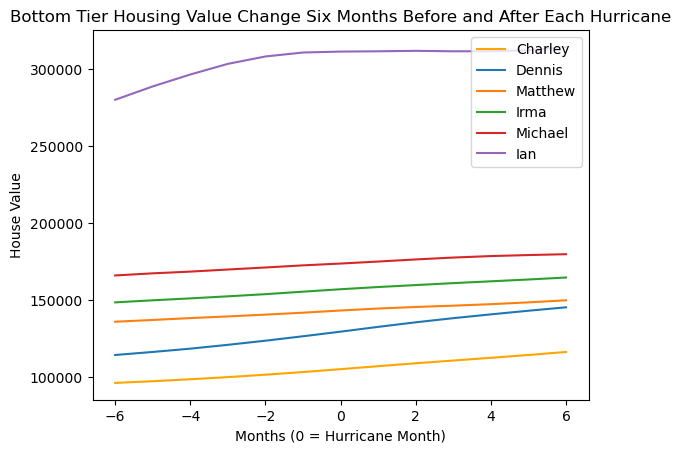

In [29]:
import matplotlib.pyplot as plt
# Visualizing The Value Change of Homes Six Months Before and After Each Hurricane
  
# to set the plot size
plt.figure()
  
# using plot method to plot values.
# in plot method we set the label and color of the curve
charley_graph['value'].plot(label='Charley', color='orange')
dennis_graph['value'].plot(label='Dennis')
matthew_graph['value'].plot(label='Matthew')
irma_graph['value'].plot(label='Irma')
michael_graph['value'].plot(label='Michael')
ian_graph['value'].plot(label='Ian')
  
# adding title to the plot
plt.title('Bottom Tier Housing Value Change Six Months Before and After Each Hurricane')
  
# adding label to the x-axis
plt.xlabel('Months (0 = Hurricane Month)')

# adding label to the y-axis
plt.ylabel('House Value')
  
# adding legend to the curve
plt.legend();

### Wind Speed 

#### Visualizing Wind Speed 

As we can see from the box and whisker plot below the largest hurricane was Irma and Ian. The variable of average wind speed is a recording of the average wind speed for the whole day. While other hurricanes may have had significant wind gusts and max speeds, what made hurricanes like Irma and Ian unique devastating was that they were extremely slow moving and stagnant. We can also see from the scatterplots below that each hurricane has a unique path. While coastal cities do tend to take more damage, at times inland regions can also experience severe damage. 


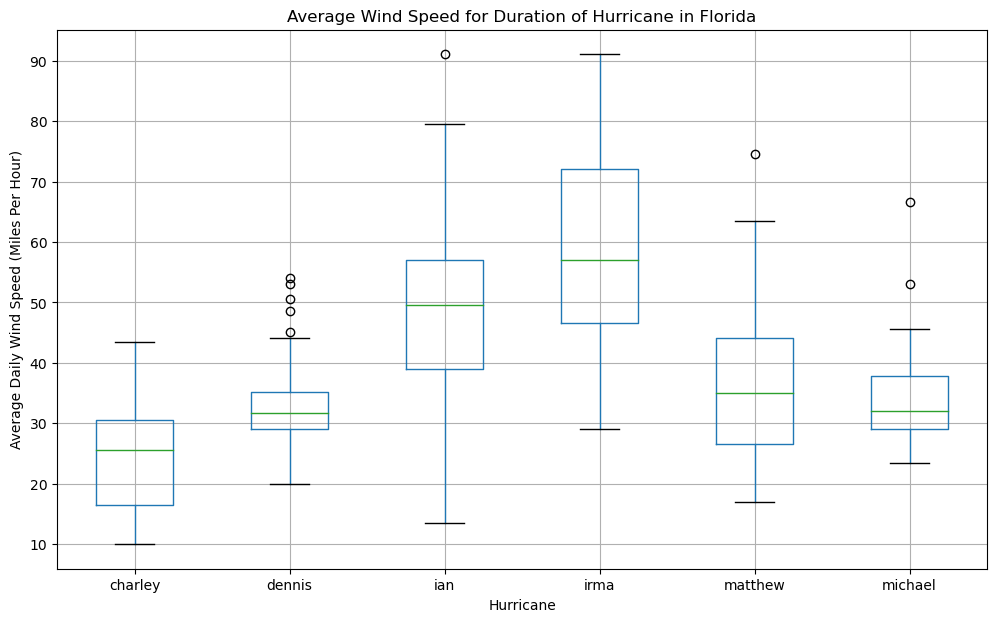

In [14]:
#Generate a box and whiskers plot for all six hurricanes
#creating a dataframe that has just HurricaneName and AWND
hurricane_bw = hurricane[['HurricaneName', 'AWND']]
#pivoting the values 
hurricane_bw = hurricane_bw.pivot(columns='HurricaneName', values='AWND')
#plotting
box = hurricane_bw.boxplot(figsize = (12,7,));
box.plot()
#adding title
plt.title('Average Wind Speed for Duration of Hurricane in Florida')
#adding xlabel 
plt.xlabel('Hurricane')
#adding ylabel
plt.ylabel('Average Daily Wind Speed (Miles Per Hour)');

In [15]:
#creating a scatterplot function 
def scatterplot(df):
    #importing image for background 
    img = plt.imread(r"data\images\floridamap.jpg")
    fig, ax = plt.subplots()
    ax.imshow(img, extent=[-87, -80, 25, 31])
    #plotting scatter plot 
    plt.scatter(x=df['LONGITUDE'], y=df['LATITUDE'], s=50, c=df['WSF2'], cmap='plasma')
    #title
    plt.title('Fastest 2 Minute Wind Gust')
    #xlabel
    plt.xlabel('Longitude')
    #y label
    plt.ylabel('Latitude')
    #legend
    ax.legend(df['HurricaneName'])
    return plt.show()

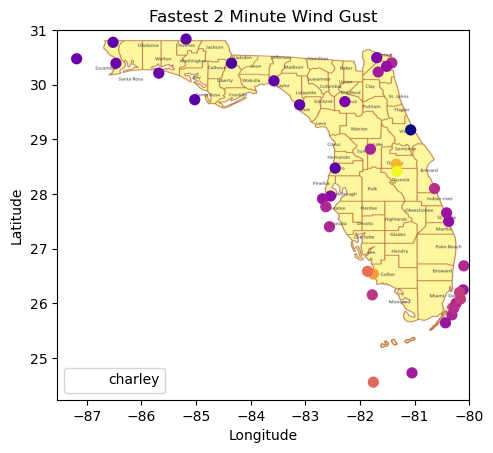

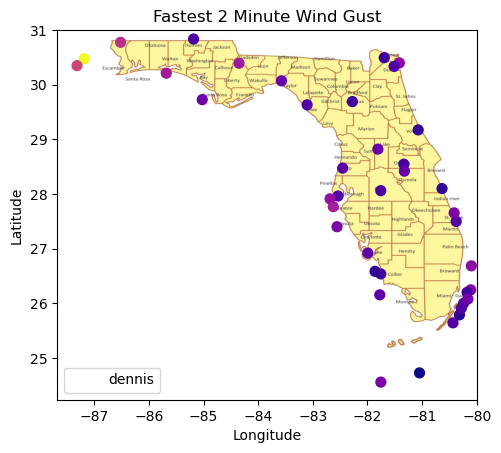

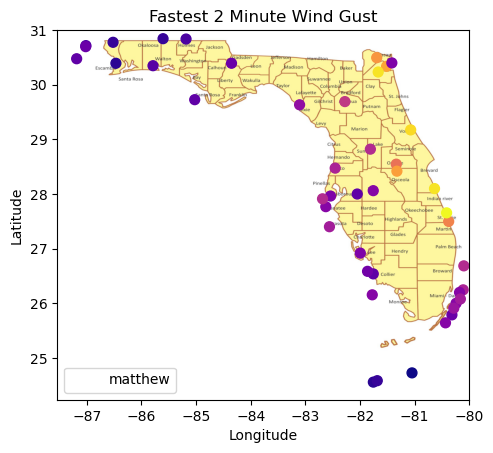

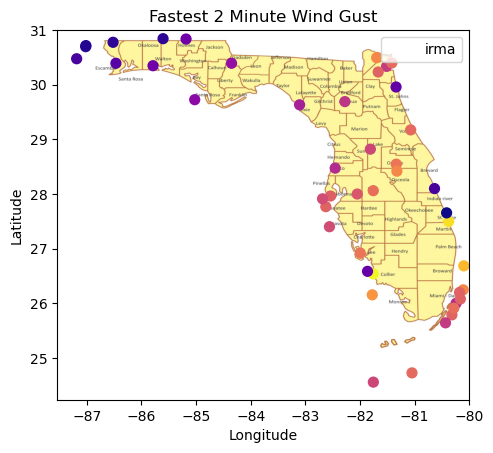

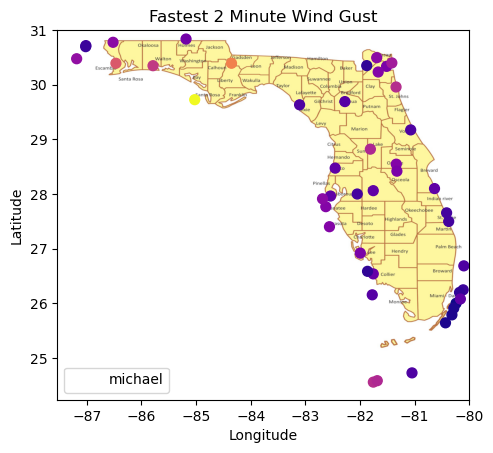

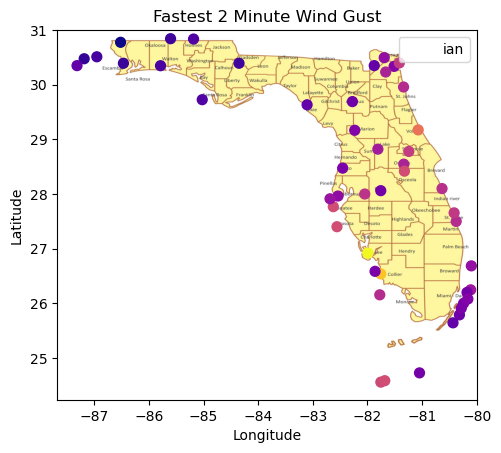

In [16]:
#applying scatterplot function to our hurricanes
scatterplot(charley)
scatterplot(dennis)
scatterplot(matthew)
scatterplot(irma)
scatterplot(michael)
scatterplot(ian)

### Correlation

The most highly correlated variable to our target variable is before prices. 

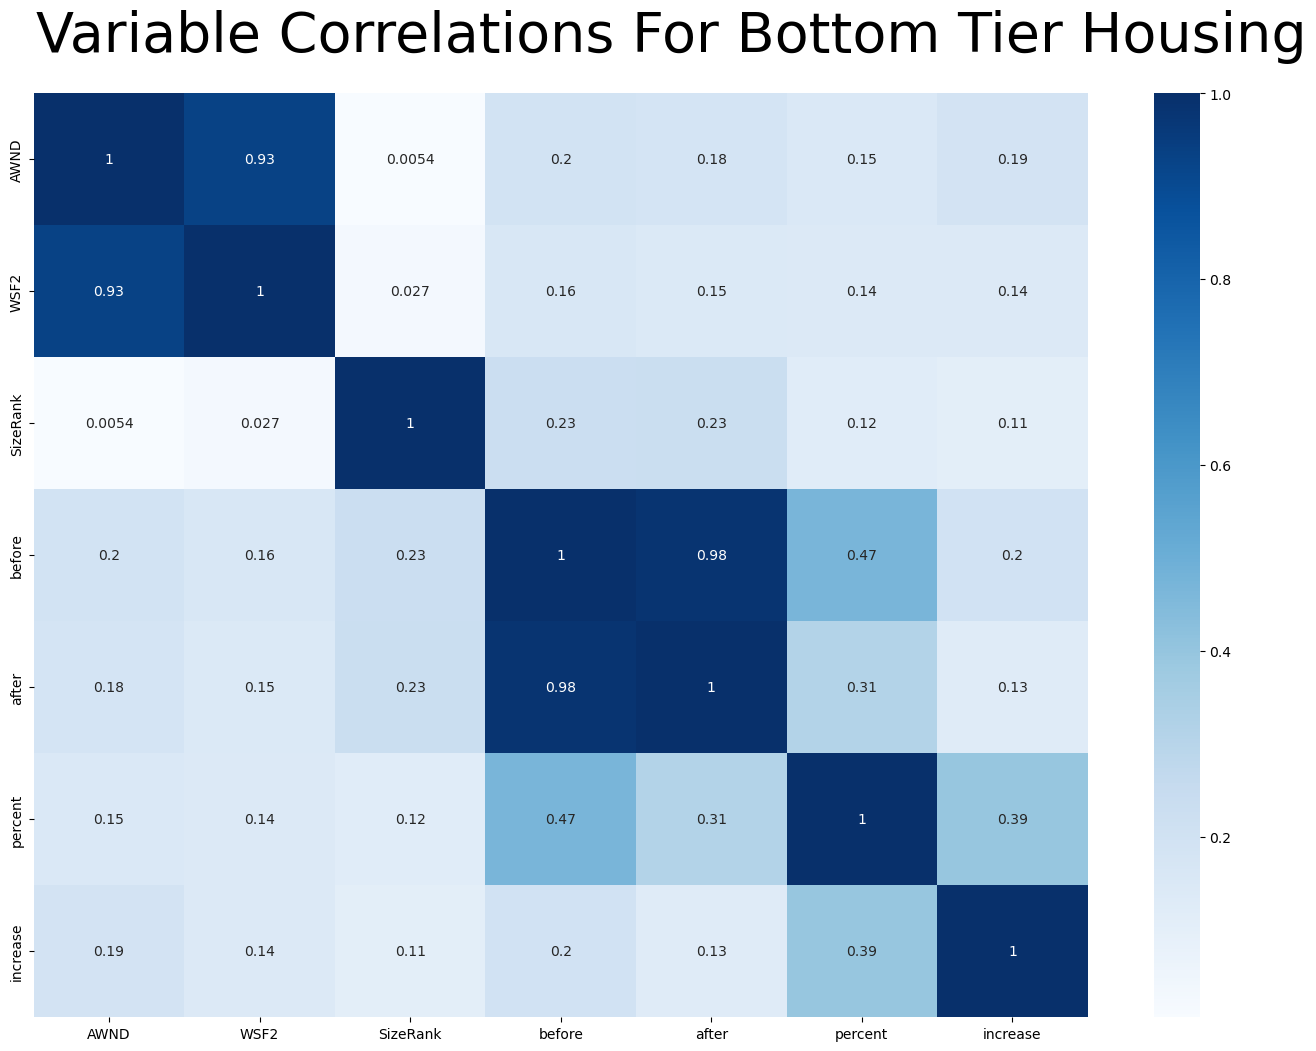

In [18]:
#checking variable correlations for bottom tier housing 
#high correlation between AWND and WSF2
#high crrelation between before and after
corr = bottom_hurricane.corr().abs()
fig, ax=plt.subplots(figsize=(17,12))
fig.suptitle('Variable Correlations For Bottom Tier Housing', fontsize=40, y=.95, fontname='DejaVu Sans')
heatmap = sns.heatmap(corr, cmap='Blues', annot=True)

#### Pairplot 
We can also see from the pairplot that the wind features have a right handed tail which is expected because higher wind values only occur during strong storms.

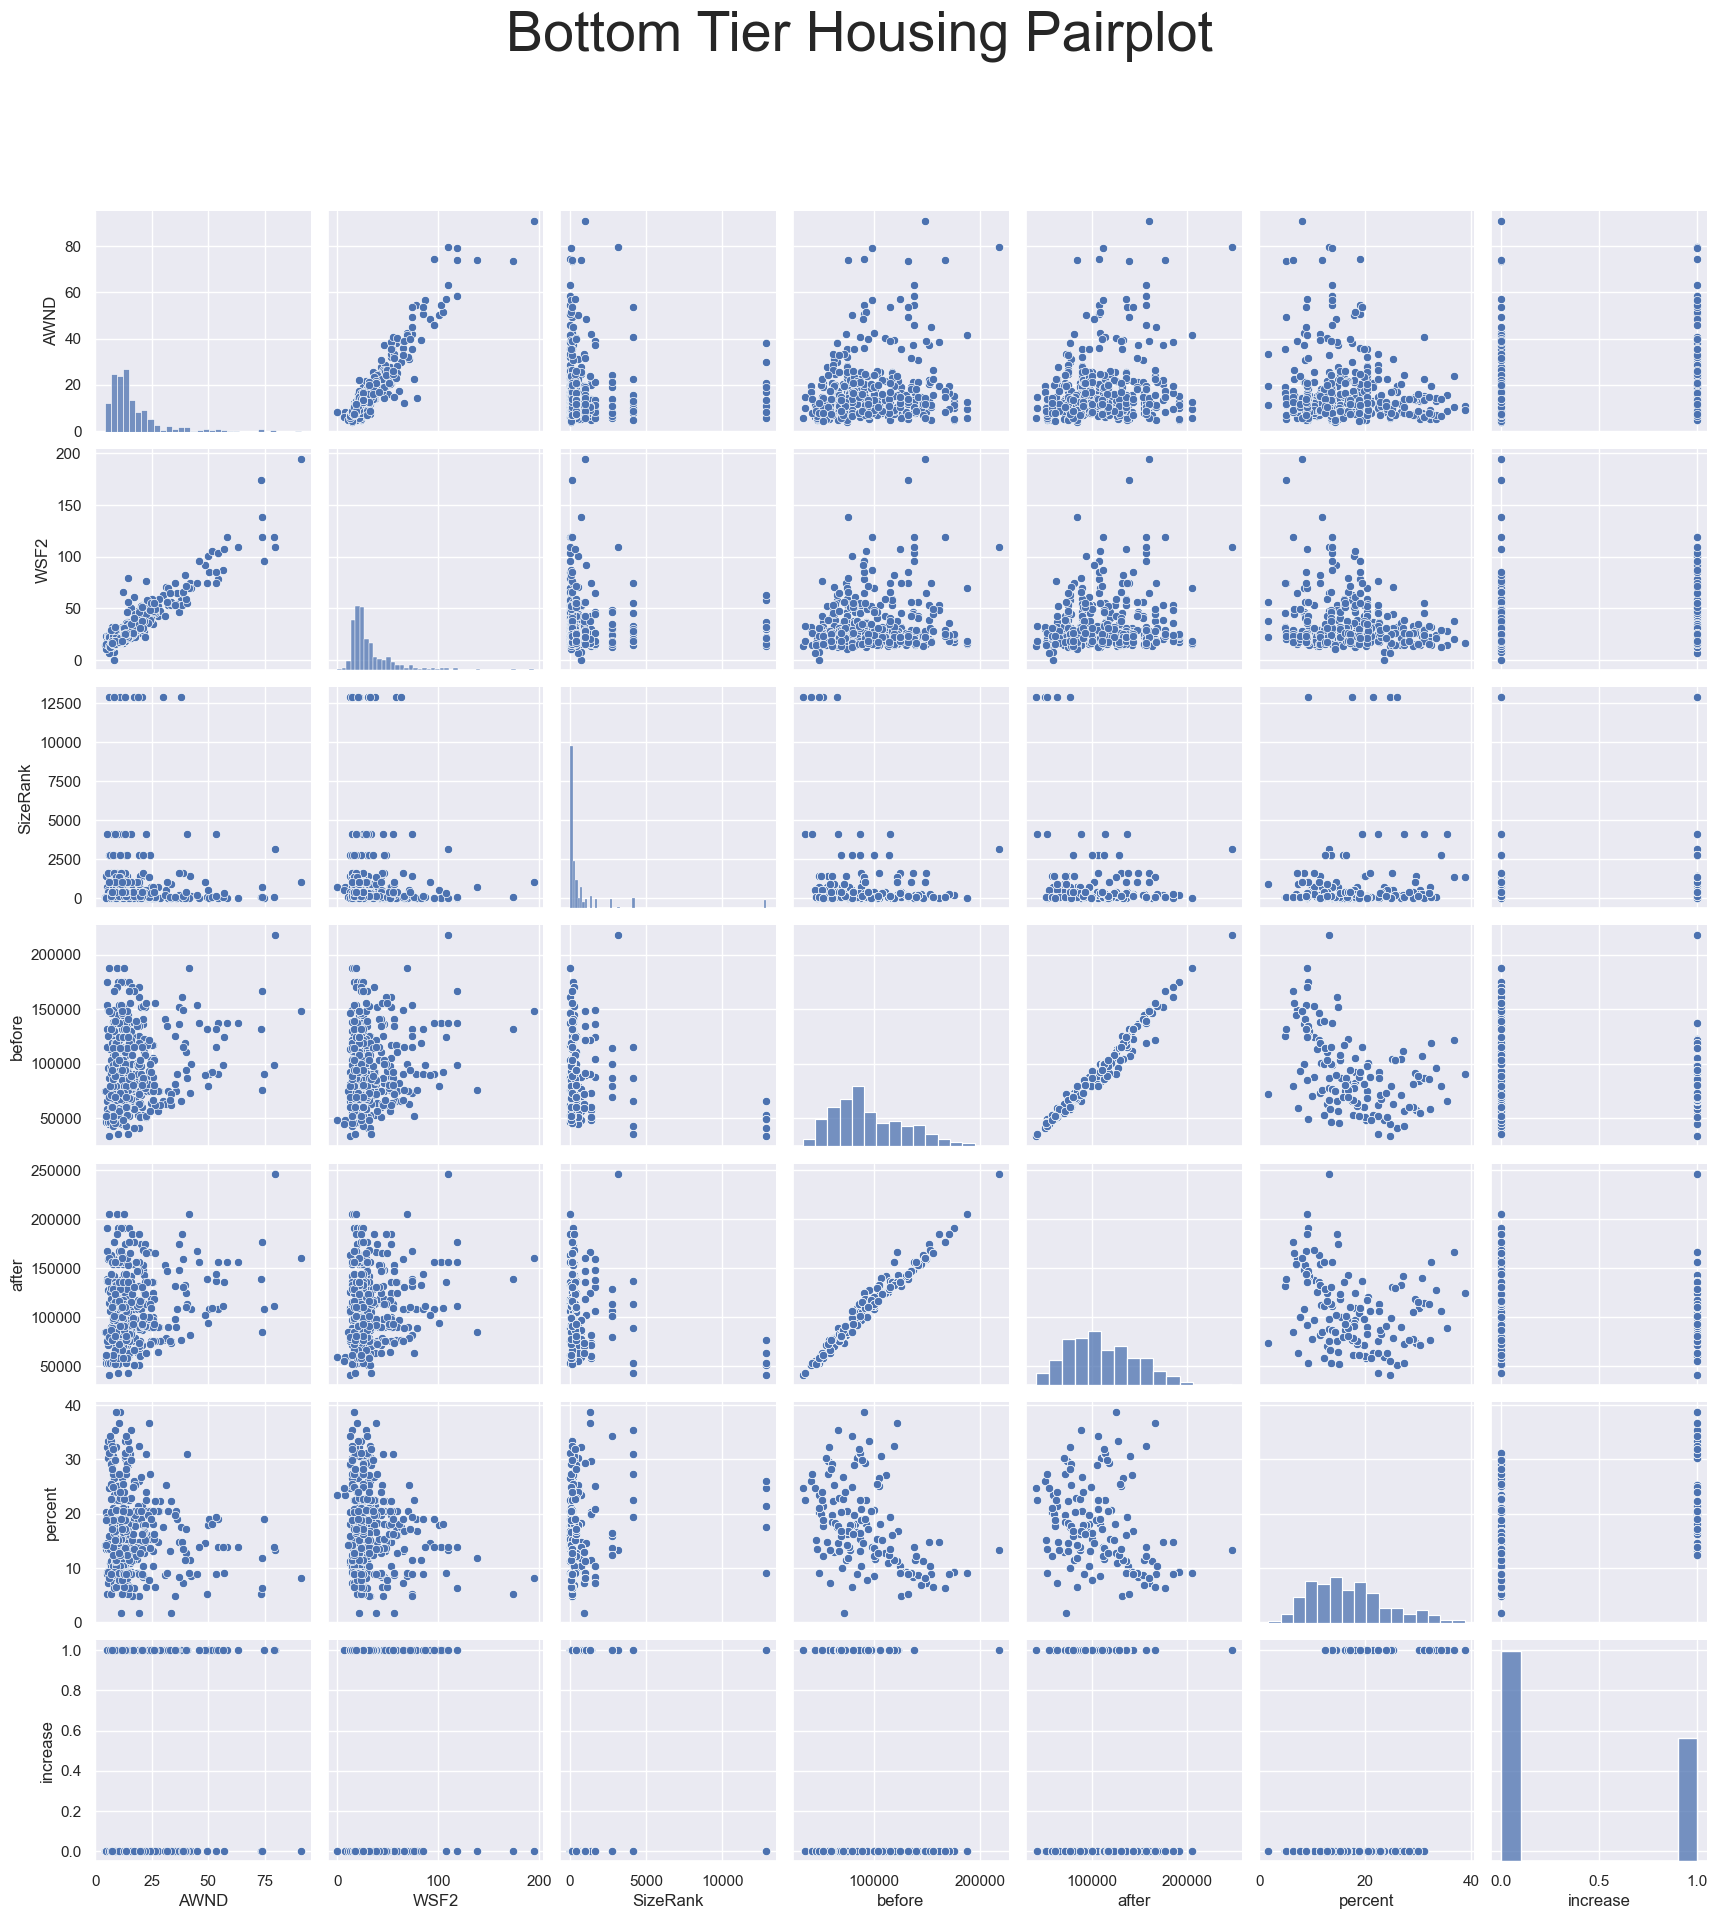

In [21]:
#plotting bottom_hurricane
#long tail on AWND and WSF2
sns.set()
s = sns.pairplot(bottom_hurricane, size = 2.5)
s.fig.suptitle("Bottom Tier Housing Pairplot", y= 1.1, fontsize=40)
plt.show();

#### Comparing Crosstabs by Target Variable

We can see by comparing the crosstabs by our target variable that the standard deviations for wind features are not hugely different. However, the standard deviation for SizeRank and before prices are. This indicates that SizeRank and before prices will probably have more of an impact on our target variable. 


In [7]:
#check crosstabs 
bottom[bottom['increase'] == 0].describe()

AWND       WSF2      SizeRank         before          after  \
count  96.000000  96.000000     96.000000      96.000000      96.000000   
mean   16.828333  31.587500    778.479167   95519.992225  109226.353419   
std     7.510509  13.880939   1933.043703   36589.222256   38580.694737   
min     4.700000   0.000000     12.000000   35072.914710   42936.584540   
25%    12.750000  23.000000    109.000000   67085.771493   77117.054463   
50%    14.430000  26.950000    219.000000   87921.154230  106197.766650   
75%    19.460000  36.000000    714.000000  124777.238250  137188.222700   
max    40.260000  79.000000  12877.000000  187941.971100  204898.395000   

         percent  increase  
count  96.000000      96.0  
mean   15.737500       0.0  
std     7.428945       0.0  
min     1.715556       0.0  
25%     9.294061       0.0  
50%    13.545954       0.0  
75%    21.427859       0.0  
max    31.148843       0.0

In [8]:
#check crosstabs 
bottom[bottom['increase'] == 1].describe()

AWND       WSF2      SizeRank         before          after  \
count  45.00000  45.000000     45.000000      45.000000      45.000000   
mean   19.71000  36.360000   1614.733333   81869.675339   99918.350911   
std     7.55599  14.072933   3251.236781   22972.899025   28216.775660   
min     5.82000  13.000000     12.000000   33025.679010   41196.088340   
25%    13.87000  25.900000    105.000000   65732.062590   78209.741850   
50%    19.46000  31.100000    350.000000   79706.029380   97547.957590   
75%    23.71000  52.100000   1343.000000   94132.640630  113361.292200   
max    40.71000  70.900000  12877.000000  137614.499600  166366.441400   

         percent  increase  
count  45.000000      45.0  
mean   22.208175       1.0  
std     6.973273       0.0  
min    12.376811       1.0  
25%    17.496982       1.0  
50%    19.823318       1.0  
75%    24.912005       1.0  
max    38.720009       1.0

#### Class Imbalance

In order to know what a good accuracy is for our models, we must know what the majority class percent is. This will tell us if our model performs any better than just selecting the majority class each time. From the count plots below we can see that the average class imbalance is 74%, which makes sense because our cutoff value was the 75th percentile. 

|Dataset | Increase | No Increase | No Increase as Percent |
|---|---|---|---|
|Bottom Tier| 45 | 96| 68% |
|Middle Tier| 33 | 106 | 76% |
|Top Tier| 28 | 114 | 80% |
|All| 89 | 255 | 74% |

#### Bottom Tier Class Imabalance

0    96
1    45
Name: increase, dtype: int64
majority percent is 68.08510638297872 %


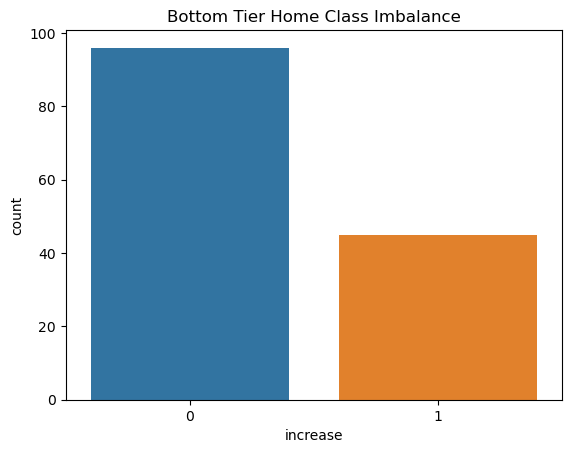

In [15]:
# Checking the balance of target variable 'increase'
sns.countplot(x='increase', data=bottom).set(title='Bottom Tier Home Class Imbalance')
print(bottom['increase'].value_counts())
#checking ratio to see what accuracy is like
percent_bottom = (len(bottom['increase']) - bottom['increase'].sum())/(len(bottom['increase']) - bottom['increase'].sum()+bottom['increase'].sum())*100
print("majority percent is {}".format(percent_bottom),"%")


## Modeling 

Of equal concern to the business problem was the model predicting False Negatives or False Positives. In this situation both are of equal importance to our real estate client. If the model predicts that the home value will not increase but it does (false negative) then our client could lose out on a possible higher return on a home. However, if the model predicts that the home value will increase but it does not (false positive) then our client may have invested money into a home that does not pay off. 

For the scope of this project we will be using accuracy and F1 score to assess our model performance. Since we had a class imbalance we could not solely rely on accuracy to communicate model performance. Since, precision and recall were of equal importance for our business problem F1 score was used to assess model performance. 

- **Model accuracy** is a machine learning classification model performance metric that takes the ratio of true positives and true negatives to all positives and negative results. It communicates how often our model will correctly predict an outcome out of the total number of predictions made. However, accuracy metrics are not always reliable for imbalance datasets. Accuracy Score = (TP + TN)/ (TP + FN + TN + FP)  

- **Model F1 Score** is a model performance metric that gives equal weight to both the Precision and Recall for measuring performance. F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)    

- **ROC-AUC** The Receiver Operator Characteristic (ROC) curve is used to assess a model’s ability to correctly classify by plotting the true positive rate against the false positive rate. A curve that ‘peaks’ more quickly communicates that there is a good true positive rate and a low false positive rate. The area under the curve (AUC) is derived from ROC and has a baseline chance of 50% accuracy, hence, an AUC closer to 1 signifies a better classification model.

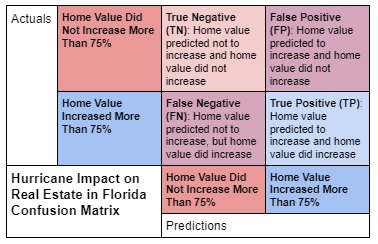

**Works Cited**   
Filho M. How To Get Feature Importance In Logistic Regression. forecastegy.com. Published March 30, 2023. Accessed July 10, 2023. https://forecastegy.com/posts/feature-importance-in-logistic-regression/#feature-importance-in-binary-logistic-regression     
Kumar A. Accuracy, Precision, Recall & F1-Score - Python Examples. Data Analytics. Published October 1, 2021. https://vitalflux.com/accuracy-precision-recall-f1-score-python-example/

### Logistic Regresion

We chose to use a logistic regression model because this is a classification issue and this model works well with categorical data. The model had a default penalty of L2. 

A logistic regression model was iterated through with our scaled data. We removed collinear variables and used SMOTE to adjust for the class imbalance. The logistic regression model that performed the best was our SMOTE model with no colinear features and had an accuracy of 0.74 which was slightly better than our baseline accuracy of 0.68 and an F1 score of 0.68. 

In [19]:
#establishing model 
logreg = LogisticRegression(random_state=56)

### Logistic Regression Model

### Selecting our Target Variable and Features
We will use the bottom tier housing for modeling since it has the best class imbalance. For our features we dropped WSF2 because it was colinear with AWND. 

In [46]:
#y is prediction variable 
#X is features 
y = bottom['increase']
X = bottom.drop(['City', 'HurricaneName', 'DATE', 'after', 'percent', 'increase', 'WSF2'], axis=1)

### Train/Test Split
In order to know how well our model performs we need to test it on data it has not seen. We will use a train/test split to save 30% of our dataset for testing the model. 

In [47]:
#performing train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=56)

### Scaling Our Data

Currently our dataset contains features that are measured in various way (price, speed, size), in order for our machine learning models to interpret these features they need to be on the same scale, so we will perform scaling. 

In [48]:
#initiating Standard Scaler
sc = StandardScaler()
#fitting
sc.fit(X_train)
#tranforming X train and test
X_train = sc.transform(X_train)
X_test= sc.transform(X_test)

### Synthetic Minority Oversampling Technique (SMOTE)

Due to the class imbalance in our dataset SMOTE may be effective in improving our model performance. SMOTE can be used to increase the number of cases in our dataset in a balanced way. 

In [49]:
# Create instance of smotec
from imblearn.over_sampling import SMOTE,SMOTENC
# set sampling_strategy to 0.8 to avoid oversampling
smote = SMOTE(sampling_strategy=0.8, random_state=56)

In [50]:
# Create resampled version of the train dataset
SMOTE_X_train, SMOTE_y_train = smote.fit_resample(X_train, y_train)
# Create resampled version of the test dataset
SMOTE_X_test, SMOTE_y_test = smote.fit_resample(X_test, y_test)

In [51]:
#before smote
print('Before Smote\n', y_train.value_counts())

#after smote
print('\nAfter Smote\n', SMOTE_y_train.value_counts())

Before Smote
 0    65
1    33
Name: increase, dtype: int64

After Smote
 0    65
1    52
Name: increase, dtype: int64


### Training Data

Our accuracy is worse than the baseline and previous models, but the F1 score is improving. 

In [52]:
#fitting the model unto our training data
logreg.fit(SMOTE_X_train, SMOTE_y_train)
y_pred_train = logreg.predict(SMOTE_X_train)

#### Checking Metrics

In [53]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(SMOTE_y_train, y_pred_train))

Accuracy: 0.641


In [54]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(SMOTE_y_train, y_pred_train))

F1 Score: 0.553


### Testing Data
The model accuracy on the testing data is better than the baseline. However, the F1 score did improve with SMOTE. The AUC value is .77 which means it's classifying better than just random chance. There are more false negatives than false positive which is slightly preferable for our client. And average wind speed is the most important feature.  

In [55]:
#fitting the model unto our test data
logreg.fit(SMOTE_X_test, SMOTE_y_test)
y_pred_test = logreg.predict(SMOTE_X_test)

#### Checking Metrics

In [56]:
#Printing Accuracy
accuracy_3 = accuracy_score(SMOTE_y_test, y_pred_test)
print(accuracy_3)

0.7454545454545455


In [57]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
F1_3 = f1_score(SMOTE_y_test, y_pred_test)
print(F1_3)

0.6818181818181818


In [58]:
#adding metrics to dictionary
model_dict['LGRModel3_Accuracy'] = accuracy_3
model_dict['LGRModel3_F1'] = F1_3
model_dict

{'Baseline Accuracy': 68.08510638297872,
 'LGRModel1_Accuracy': 0.7441860465116279,
 'LGRModel1_F1': 0.35294117647058826,
 'LGRModel2_Accuracy': 0.7674418604651163,
 'LGRModel2_F1': 0.375,
 'LGRModel3_Accuracy': 0.7454545454545455,
 'LGRModel3_F1': 0.6818181818181818}

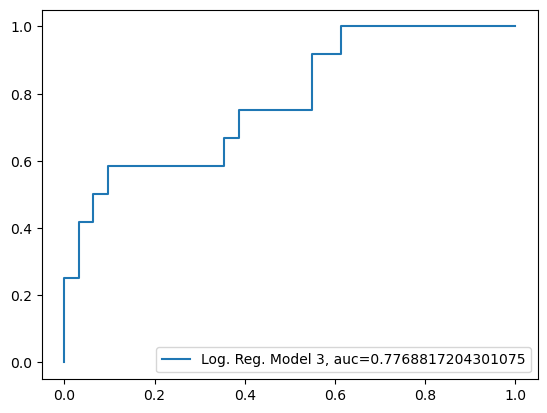

In [59]:
#let's check out the AUC curve
#getting probability
y_pred_prob = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_prob)
auc = metrics.roc_auc_score(y_test, y_pred_prob)

#plotting
plt.plot(fpr,tpr,label="Log. Reg. Model 3, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### Confusion Matrix

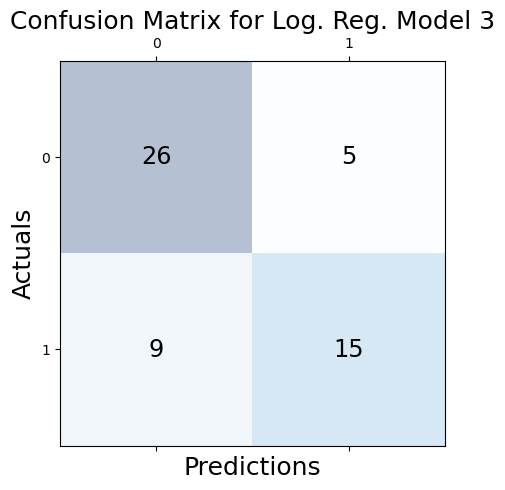

In [60]:
#getting confusion matrix values
conf_matrix = confusion_matrix(y_true=SMOTE_y_test, y_pred=y_pred_test)
#plotting
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
#assigning labels 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for Log. Reg. Model 3', fontsize=18)
plt.show()

### Feature Importance

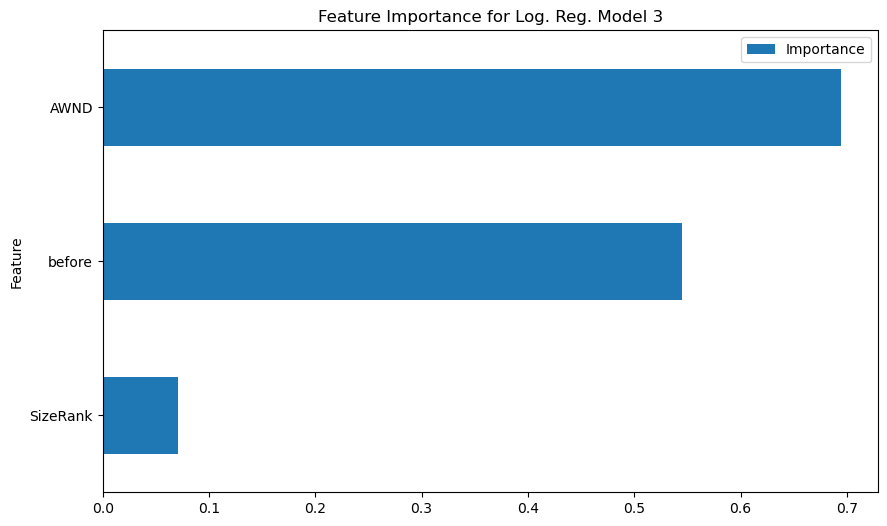

In [61]:
#initiating model 
model = LogisticRegression()
#fitting model 
model.fit(SMOTE_X_train, SMOTE_y_train)
#getting coefficients 
coefficients = model.coef_[0]
#plotting feature_importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', title= 'Feature Importance for Log. Reg. Model 3', figsize=(10, 6));

## XGBoost

In [62]:
#initiating model
xgb = XGBClassifier(random_state=56)

### Selecting Our Target Variable and Features

Let's first run the model with all features. 

In [63]:
#y is prediction variable 
#X is features 
y_boost = bottom['increase']
X_boost = bottom.drop(['City', 'HurricaneName', 'DATE', 'after', 'percent', 'increase'], axis=1)

### Train/Test Split

In [64]:
#train/test splits with 30% test size
XG_X_train, XG_X_test, XG_y_train, XG_y_test = train_test_split(X_boost, y_boost, test_size=0.30, random_state=56)

### Training Data

Using XG Boost we get perfect accuracy. 

In [65]:
#fitting the model 
xgb.fit(XG_X_train, XG_y_train);

In [66]:
#getting predictions
y_pred_train = xgb.predict(XG_X_train)

In [67]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(XG_y_train, y_pred_train))

Accuracy: 1.000


In [68]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(XG_y_train, y_pred_train))

F1 Score: 1.000


### Testing Data

In [69]:
#fitting the model 
xgb.fit(XG_X_test, XG_y_test);

In [70]:
#getting predictions 
y_pred_test = xgb.predict(XG_X_test)

In [71]:
#Printing Accuracy
accuracy_XG1 = accuracy_score(XG_y_test, y_pred_test)
print(accuracy_XG1)

1.0


In [72]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
F1_XG1 = f1_score(XG_y_test, y_pred_test)
print(F1_XG1)

1.0


In [73]:
#adding values to dictionary
model_dict['XGBoost_Accuracy'] = accuracy_XG1
model_dict['XGBoost_F1'] = F1_XG1
model_dict

{'Baseline Accuracy': 68.08510638297872,
 'LGRModel1_Accuracy': 0.7441860465116279,
 'LGRModel1_F1': 0.35294117647058826,
 'LGRModel2_Accuracy': 0.7674418604651163,
 'LGRModel2_F1': 0.375,
 'LGRModel3_Accuracy': 0.7454545454545455,
 'LGRModel3_F1': 0.6818181818181818,
 'XGBoost_Accuracy': 1.0,
 'XGBoost_F1': 1.0}

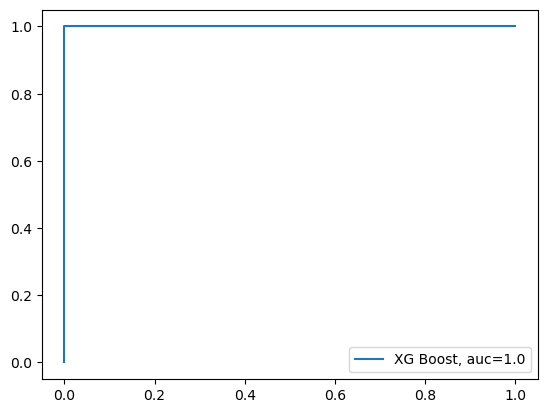

In [74]:
#let's check out the AUC curve
#getting probability
y_pred_prob = xgb.predict_proba(XG_X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(XG_y_test,  y_pred_prob)
auc = metrics.roc_auc_score(XG_y_test, y_pred_prob)

#plotting
plt.plot(fpr,tpr,label="XG Boost, auc="+str(auc))
plt.legend(loc=4)
plt.show()

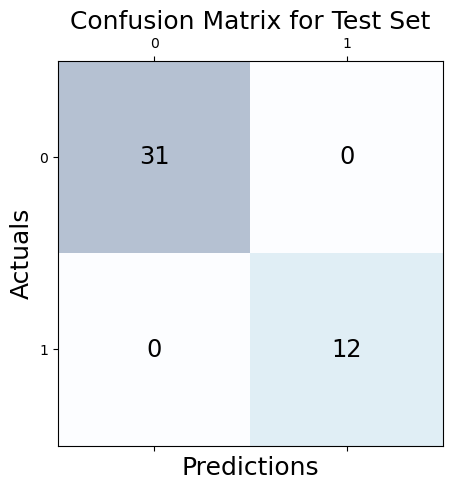

In [75]:
#checking confusion matrix
conf_matrix = confusion_matrix(y_true=XG_y_test, y_pred=y_pred_test)

#plotting confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
        
#assigning labels 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for Test Set', fontsize=18)
plt.show()

## Feature Importance using SHAP (SHapley Additive exPlanations) 

SHAP is used to explain the output of machine learning models. Using a beeswarm plot can reveal the importance of features and their relationship with the predicted outcome. 

shap_values: is the average contribution of each of the features to the prediction for each sample based on alll the possible features. 

From the plot below we can interpret that:
- larger SizeRank values have a higher impact on feature value     
- smaller before values have a higher impact on feature value      
- higher WSF2 and AWND values have higher impact on feature value      

Works Cited   
Classification Feature Selection : SHAP Tutorial. kaggle.com. Accessed July 6, 2023. https://www.kaggle.com/code/ritzig/classification-feature-selection-shap-tutorial#SHAP


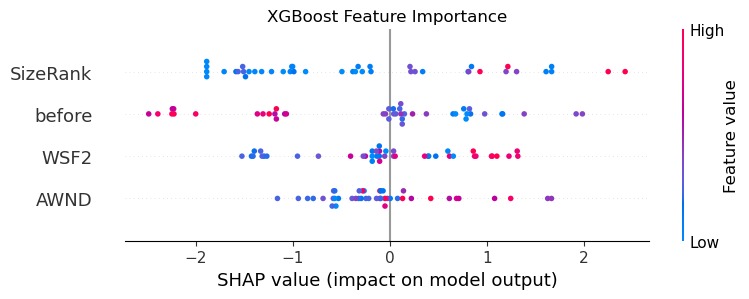

In [76]:
#Using SHAP to assess feature importance 
#creating an explainer for our model
explainer = shap.TreeExplainer(xgb)

# finding out the shap values using the explainer
shap_values = explainer.shap_values(XG_X_test)

#creating a beeswarm plot 
shap.initjs()
plt.title("XGBoost Feature Importance", y=1)
shap.summary_plot(shap_values, XG_X_test)

# Best Model: XGBoost
We ran two types of models, logistic regression and XG Boost. The best logisitc regression model (model 3 with SMOTE) had an accuracy of 74% which is only slightly better than the majority percent of 68% and an F1 score of 0.68 on the testing data. Our best model was XGBoost which had a perfect accuracy and F1 score with the included features:
- AWND
- WSF2
- SizeRank
- before 

While the logistic regression models had AWND as the top feature, the XG Boost model had SizeRank as the top feature. 

In [77]:
#pulling up model accuracy and F1 score for all models 
model_dict

{'Baseline Accuracy': 68.08510638297872,
 'LGRModel1_Accuracy': 0.7441860465116279,
 'LGRModel1_F1': 0.35294117647058826,
 'LGRModel2_Accuracy': 0.7674418604651163,
 'LGRModel2_F1': 0.375,
 'LGRModel3_Accuracy': 0.7454545454545455,
 'LGRModel3_F1': 0.6818181818181818,
 'XGBoost_Accuracy': 1.0,
 'XGBoost_F1': 1.0}

## Model Validation 

In order to know how the model would perform on real world data we will validate it using data from Hurricane Ian. This is data the model has never seen. The model performed with 74% accuracy which is better than the baseline accuracy of 59%. And had an F1 score of 0.533 and an AUC value of 0.92. Of 27 predictions 7 were false negatives and none were false positives. 

### XGBoost on Hurricane Ian Data

0    16
1    11
Name: increase, dtype: int64
majority percent is 59.25925925925925 %


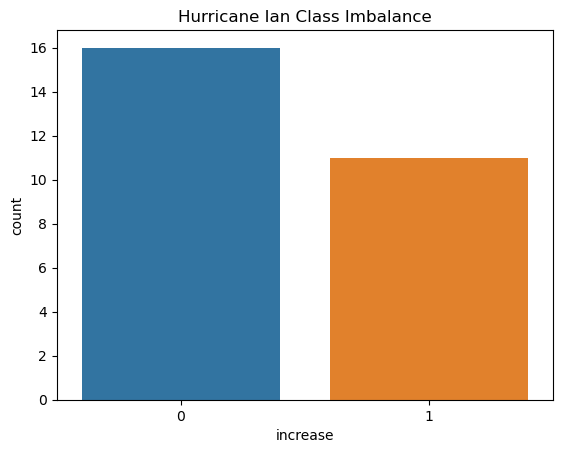

In [78]:
# Checking the balance of target variable 'increase'
#plotting 
sns.countplot(x='increase', data=all_ian).set(title='Hurricane Ian Class Imbalance')
#print value counts 
print(all_ian['increase'].value_counts())
#checking ratio to see what accuracy is like
percent = (len(all_ian['increase']) - all_ian['increase'].sum())/(len(all_ian['increase']) - all_ian['increase'].sum()+all_ian['increase'].sum())*100
print("majority percent is {}".format(percent),"%")

### Selecting Our Target Variable and Features


In [79]:
#y is target variable 
#X is features 
y_ian = all_ian['increase']
X_ian = all_ian.drop(['City', 'HurricaneName', 'DATE', 'after', 'percent', 'increase'], axis=1)

In [80]:
#getting prediction
y_pred = xgb.predict(X_ian)

In [81]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(y_ian, y_pred))

Accuracy: 0.741


In [82]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(y_ian, y_pred))

F1 Score: 0.533


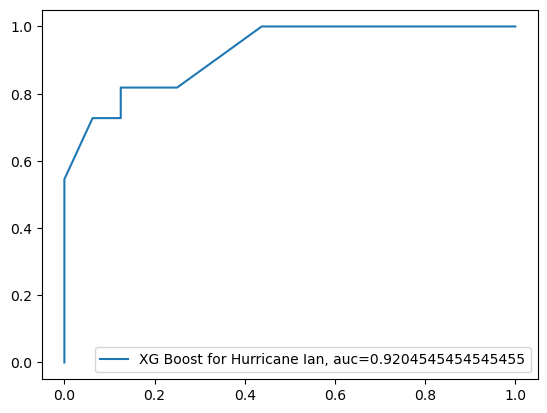

In [83]:
#let's check out the AUC curve
#getting probability
y_pred_prob = xgb.predict_proba(X_ian)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_ian,  y_pred_prob)
auc = metrics.roc_auc_score(y_ian, y_pred_prob)

#plotting
plt.plot(fpr,tpr,label="XG Boost for Hurricane Ian, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### Confusion Matrix

As seen below 7 false negatives were predicted. Meaning home value was predicted not to increase, but it did. 

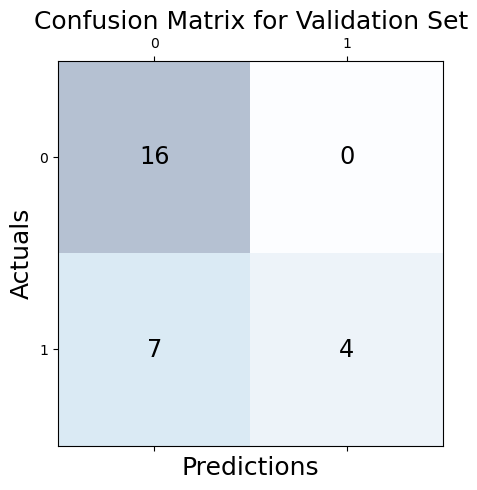

In [84]:
conf_matrix = confusion_matrix(y_true=y_ian, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for Validation Set', fontsize=18)
plt.show()

## Exploring Wind Speed and Model Tuning 

### XG Boost Tuning

Let's see if we can improve our results using just wind features with model tuning. The optimal parameters according to the gridsearch are:

Best Parameters for Our XGBoost Model:  
{'gamma': 0,  
 'learning_rate': 0.01,  
 'max_depth': 2,  
 'min_child_weight': 1,  
 'n_estimators': 10,  
 'subsample': 0.5}  
 

### How Do Wind Speed Features Impact Model Performance
For the scope of this project we are particularly interested in how hurricane's impact real estate value. Using wind speed we were able to gauge how much damage a hurricane had on a certain area. The most important feature for our best model was the fastest 2 minute wind gust and SizeRank. When we drop the wind features from the model the accuracy drops to 0.98 and the F1 score drops to 0.96. Meaning that wind features do improve model performance. 

| Model | Accuracy | F1 |  AUC |
|-- | -- | -- | -- |
| No Wind | 0.98 | 0.96 | 0.99 |   
| Just Wind | 0.96 | 0.91 |  0.98 |    
| Just Wind (Tuned) | 0.78 | 0.56 |  0.80 | 



## Recommendations 
- Looking into larger cities and regions with lower than average home prices 

- Wind speed features do slightly improve model performance and have a correlation with the target variable that is similar to that of SizeRank and before prices

- Use the XG Boost model to attempt to buy homes after the next hurricane to see if the model is effective in making business decisions

## Futher Improvements
- Continue collecting data as new hurricanes hit Florida
- Looking at a different region which is impacted by hurricanes, such as Texas, to see how flexible the model is 
